Word Embeddings
===============

Our sessions so far have worked off the idea of document annotation to produce new, sometimes highly useful metdata about texts. We've used this information for everything from information retrieval tasks (Chapter 2) to predictive classification (Chapter 3). Along the way, we've also made some passing discussions about how such annotations work to quantify or identify the semantics of those tasks (our work with POS tags, for example). But what we haven't yet done is produce a model of semantic meaning ourselves. This is another core task of NLP, and there are several different ways to approach building a statistical representation of tokens' meanings. The present chapter discusses one of the most popular methods of doing so: **word embeddings**. Below, we'll overview what word embeddings are, demonstrate how to build and use them, talk about important considerations regarding bias, and apply all this to a document clustering task.

The corpus we'll use is Melanie Walsh’s [collection] of ~380 obituaries from the _New York Times_. If you participated in our Getting Started with Textual Data series, you'll be familiar with this corpus: we used it [in the context of tf-idf scores]. Our return to it here is meant to chime with that discussion, for word embeddings enable us to perform a similar kind of text vectorization. Though, as we'll discuss, the resultant vectors will be considerably more feature-rich than what we could achieve with tf-idf alone.

[collection]: https://melaniewalsh.github.io/Intro-Cultural-Analytics/00-Datasets/00-Datasets.html
[in the context of tf-idf scores]: https://ucdavisdatalab.github.io/workshop_getting_started_with_textual_data/05_clustering-and-classification.html

```{admonition} Learning objectives
By the end of this chapter, you will be able to:
+ Explain what word embeddings are
+ Use `gensim` to train and load word embeddings models
+ Identify and analyze word relationships in these models
+ Recognize how bias can inhere in embeddings
+ Encode documents with a word embeddings model
```

Word Embeddings: Introduction
-------------------------------------

Prior to the advent of [Transformer] models, word embedding served as a state-of-the-art technique for representing semantic relationships between tokens. The technique was first introduced in 2013, and it spawned a host of different variants that completely flooded the field of NLP until about 2018. In part, word embedding's popularity stems from the relatively simple intuition behind it, which is known as the **distributional hypothesis**: "a word is characterized by the company it keeps" (Firth). Words that appear in similar contexts, in other words, have similar meanings, and what word embeddings do is represent that context-specific information through a set of features. As a result, similar words share similar data representations, and we can leverage that similarity to explore the semantic space of a corpus, to encode documents with feature-rich data, and more.

If you're familiar with [tf-idf vectors], the underlying data structure of word embeddings is the same: every word is represented by a vector of _n_ features. But a key difference lies in the **sparsity** of the vectors – or, in the case of word embeddings, the _lack_ of sparsity. As we saw in the last chapter, tf-idf vectors can suffer from the [curse of dimensionality], something that's compounded by the fact that such vectors must contain features for every word in corpus, regardless of whether a document has that word. This means tf-idf vectors are highly sparse: they contain many 0s. Word embeddings, on the other hand, do not. They're what we call **dense** representations. Each one is a fixed-length, non-sparse vector (of 50-300 dimensions, usually) that is much more information-rich than tf-idf. As a result, embeddings tend to be capable of representing more nuanced relationships between corpus words – a performance improvement that is further boosted by the fact that many of the most popular models had the advantage of being trained on billions and billions of tokens.

The other major difference between tehse vectors and tf-idf lies in how the former are created. While at root, word embeddings represent token co-occurence data (just like a document-term matrix), they are the product of millions of guesses made by a neural network. Training this network involves making predictions about a target word, based on that word's context. We are not going to delve into the math behind these predictions (though [this post] does); however, it is worth noting that there are two different training set ups for a word embedding model:

```{margin} For more on CBOW vs. skip-gram
Check out this blog post, [Words as Vectors].

[Words as Vectors]: https://iksinc.online/tag/continuous-bag-of-words-cbow/
```

1. **Common Bag of Words (CBOW)**: given a window of words on either side of a target, the network tries to predict what word the target should be
2. **Skip-grams**: the network starts with the word in the middle of a window and picks random words within this window to use as its prediction targets

As you may have noticed, these are just mirrored versions of one another. CBOW starts from context, while skip-gram tries to rebuild context. Regardless, in both cases the network attempts to maximize the likelihood of its predictions, updating its weights accordingly over the course of training. Words that repeatedly appear in similar contexts will help shape thse weights, and in turn the model will associate such words with similar vector representations. If you'd like to see all this in action, Xin Rong has produced a [fantastic, interactive visualization] of how word embedding models learn.

Of course, the other way to understand how word embeddings work is to use them yourself. We'll move on to doing so now.

[Transformer]: https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)
[tf-idf vectors]: https://ucdavisdatalab.github.io/workshop_getting_started_with_textual_data/04_corpus-analytics.html#weighted-metrics-tf-idf-scores
[curse of dimensionality]: https://en.wikipedia.org/wiki/Curse_of_dimensionality
[this post]: https://medium.com/analytics-vidhya/maths-behind-word2vec-explained-38d74f32726b
[fantastic, interactive visualization]: https://ronxin.github.io/wevi/

Loading the Data
--------------------

Before we begin working with word embeddings in full, let's load a corpus manifest file, which will help us keep track of all the obituaries.

In [1]:
import pandas as pd

manifest = pd.read_csv('data/session_three/manifest.csv', index_col=0)
manifest = manifest.assign(YEAR = pd.to_datetime(manifest['YEAR'], format='%Y').dt.year)

print(
    f"Number of obituaries: {len(manifest)}",
    f"\nDate range: {manifest['YEAR'].min()}--{manifest['YEAR'].max()}"
)

Number of obituaries: 379 
Date range: 1852--2007


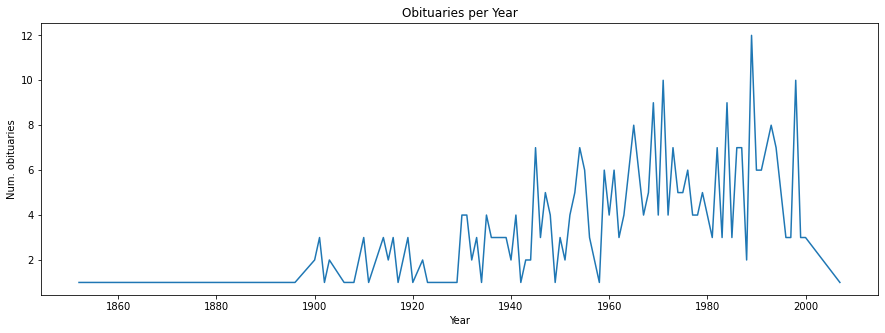

In [2]:
manifest.groupby('YEAR').count().plot(
    figsize=(15, 5),
    y='NAME',
    title='Obituaries per Year',
    ylabel='Num. obituaries',
    xlabel='Year',
    legend=False
);

Here's a sampling of the corpus:

In [3]:
for idx in manifest.sample(10).index:
    name, date = manifest.loc[idx, 'NAME'], manifest.loc[idx, 'YEAR']
    print(f"{name} ({date})")

Haile Selassie (1975)
Andres Segovie (1987)
Cole Porter (1964)
Alf Landon (1987)
David O Selznick (1965)
David Eisenhower (1969)
Geronimo (1909)
Maurice Ravel (1937)
Anwar el Sadat (1981)
Stan Kenton (1979)


Now we can load the obituaries themselves. While the past two sessions have required full-text representations of documents, word embeddings work best with bags of words, especially when it comes to doing analysis with them. Accordingly, each of the files in the corpus have already processed by a text cleaning pipeline: they represent the lowercase, stopped, and lemmatized versions of the originals.

No extra loading considerations are needed here either. We'll just use `glob` to get our file paths and iterate through the list, loading each document into a `corpus` list. Note that we still must split the file contents.

In [4]:
import glob

paths = glob.glob('data/session_three/obits/*.txt')
paths.sort()

corpus = []
for path in paths:
    with open(path, 'r') as fin:
        doc = fin.read()
        doc = doc.split()
        corpus.append(doc)

With this done, we can move on to the model.

Using an Embeddings Model
----------------------------------

At this point, we are at a crossroads. On the one hand, we could train a word embeddings model using our corpus documents as is. The `gensim` library offers functionality for this, and it's a relatively easy operation. On the other, we could use premade embeddings, which are usually trained on a more general – and much larger – set of documents. There is a tradeoff here:

+ Training a corpus-specific model will more faithfully represent the token behavior of the texts we'd like to analyze, but these representations could be _too_ specific, especially if the model doesn't have enough data to train on; the resultant embeddings may be closer to topic models than to word-level semantics
+ Using premade embeddings gives us the benefit of generalization: the vectors will cleave more closely to how we understand language; but such embeddings might a) miss out on certain nuances we'd like to capture, or b) introduce biases into our corpus (more on this below)

In our case, the decision is difficult. When preparing this reader, we (Tyler and Carl) found that a model trained on the obituaries alone did not produce vectors that could fully demonstrate the capabilities of the word embedding technique. The corpus is just a little too specific, and perhaps a little too small. We could've used a larger corpus, but doing so would introduce slow-downs in the workshop session. Because of this, we decided to use a premade model, in this case, the Stanford [GloVe] embeddings (the 200-dimension version). GloVe was trained on billions of tokens, spanning Wikipedia data, newswire articles, even Twitter. More, the model's developers offer several different dimension sizes, which are helpful for selecting embeddings with the right amount of detail.

That said, going with GloVe introduces its own problems. For one thing, we can't show you how to train a word embeddings model itself – at least not live. The code to do so, however, is reproduced below:

```{margin} Model parameters
There are many different parameters to select from in `gensim`. You can find them in the [Word2Vec documentation].

[Word2Vec documentation]: https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
```

```python
from gensim.models import Word2Vec

n_dimensions = 100
model = Word2Vec(n_dimensions)
model.build_vocab(corpus)
model.train(corpus, total_words=model.corpus_total_words, epochs=5)
```

Another problem has to do with the data GloVe was trained on. It's so large that we can't account for all the content, and this becomes particularly detrimental when it comes to bias. [Researchers have found] that general embeddings models reproduce gender-discriminatory language, even hate speech, by virtue of the fact that they are trained on huge amounts of text data, often without consideration of whether the content of such data is something one would endorse. GloVe is [known to be biased] in this way. We'll show an example later on in this chapter and will discuss this in much more detail during our live session, but for now just note that the effects of bias _do_ shape how we represent our corpus, and it's important to keep an eye out for this when working with the data.

[GloVe]: https://nlp.stanford.edu/projects/glove/
[Researchers have found]: https://www.technologyreview.com/2016/07/27/158634/how-vector-space-mathematics-reveals-the-hidden-sexism-in-language/
[known to be biased]: http://arxiv.org/abs/1607.06520

### Loading a model

With all that said, we can move on. Below, we load GloVe embeddings into our workspace using a `gensim` wrapper.

In [5]:
from gensim.models import KeyedVectors

model = KeyedVectors.load('data/session_three/glove/glove-wiki-gigaword_200d.bin')

The `KeyedVectors` object acts almost like a dictionary. You can do certain Python operations directly on it, like using `len()` to find the number of tokens in the model.

In [6]:
n_tokens = len(model)

print(f"Number of unique tokens in the model: {n_tokens:,}")

Number of unique tokens in the model: 400,000


### Token mappings

Each token in the model (what `gensim` calls a "key") has an associated index. This mapping is accessible via the `.key_to_index` attribute:

In [7]:
model.key_to_index

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

If you want to get the vector representation for a token, you can use either the key or the index. The syntax is just like a Python dictionary. Below, we randomly select a single token from the model vocabulary's `.index_to_key` attribute and find the index associated with it.

In [8]:
import random

rand_token = random.choice(model.index_to_key)
rand_idx = model.key_to_index[rand_token]

print(f"The index position for '{rand_token}' is {rand_idx}")

The index position for 'u.a.e.' is 56135


Here's its vector:

In [9]:
model[rand_idx]

array([-0.12157  ,  0.18633  ,  0.53312  ,  0.29472  , -0.1987   ,
        0.1607   , -0.6274   ,  0.66265  , -0.07376  , -0.14793  ,
        0.2536   ,  0.15215  ,  0.10033  ,  0.0032814,  0.099741 ,
        0.24584  , -0.42355  , -0.046631 , -0.064696 ,  0.22395  ,
        0.1096   , -0.15957  ,  0.032216 ,  0.20485  , -0.64055  ,
       -0.07877  , -0.3653   ,  0.7252   ,  0.33259  , -0.055448 ,
        0.37753  , -0.42584  ,  0.078015 , -0.22945  , -0.32251  ,
       -0.023816 , -0.096102 , -0.62685  ,  0.81967  , -0.65914  ,
        0.11942  , -0.28574  ,  0.092331 , -0.52182  , -0.21709  ,
        0.063872 , -0.52587  ,  0.062461 , -0.5442   , -0.13443  ,
       -0.18762  , -0.49456  ,  0.092859 , -0.028247 , -0.14954  ,
       -0.75058  , -0.37829  , -0.58429  ,  0.068078 , -0.55234  ,
        0.11006  , -0.17333  ,  0.078244 ,  0.23563  ,  0.11247  ,
        0.087    ,  0.25611  , -0.25113  , -0.24408  , -0.28521  ,
       -0.30043  , -0.075735 , -0.27854  ,  0.174    , -0.1526

And here we show that accessing this vector with either the index or key produces the same thing:

In [10]:
import numpy as np

np.array_equal(model[rand_idx], model[rand_token])

True

Finally, we can store the entire model vocabulary in a `set` and show a few examples of the tokens therein.

In [11]:
model_vocab = set(model.index_to_key)

for token in random.sample(model_vocab, 10):
    print(token)

bazarova
gyngell
stepan
hagana
donnay
newtownhamilton
sacranie
illiteracy
ausgleich
brohi


You may find some unexpected tokens in this output. Though it has been ostensibly trained on an English corpus, GloVe contains multilingual text. It also contains lots of noisy tokens, which range from erroneous segmentations ("drummer/percussionist" is one token, for example) to password-like strings and even HTML markup. Depending on your task, you may not notice these tokens, but they do in fact influence the overall shape of the model, and sometimes you'll find them cropping up when you're hunting around for similar terms and the like (more on this soon).

### Out-of-vocabulary tokens

While GloVe's vocabulary sometimes seems _too_ expansive, there are other instances where it's too restricted.

In [12]:
assert 'unshaped' in model, "Not in vocabulary!"

AssertionError: Not in vocabulary!

If the model wasn't trained on a particular word, it won't have a corresponding vector for that word either. This is crucial. Because models like GloVe only know what they've been trained on, you need to be aware of any potential discrepancies between their vocabularies and your corpus data. If you don't keep this in mind, sending unseen, or **out-of-vocabulary**, tokens to GloVe will throw errors in your code:

In [13]:
model['unshaped']

KeyError: "Key 'unshaped' not present"

There are a few ways to handle this problem. The most common is to simply _not encode_ tokens in your corpus that don't have a corresponding vector in GloVe. Below, we construct three dictionaries for our corpus data. The first contains all tokens, while the second and third are comprised of tokens that are and are not in Glove, respectively. We identify whether the model has a token using its `.has_index_for()` method.

In [14]:
corpus_vocab = set(token for doc in corpus for token in doc)
in_glove = set(token for token in corpus_vocab if model.has_index_for(token))
no_glove = set(token for token in corpus_vocab if model.has_index_for(token) == False)

print(
    f"Total words in the corpus vocabulary: {len(corpus_vocab):,}",
    f"\nNumber of corpus words in GloVe: {len(in_glove):,}",
    f"\nNumber of corpus words not in GloVe: {len(no_glove):,}"
)

Total words in the corpus vocabulary: 29,330 
Number of corpus words in GloVe: 27,488 
Number of corpus words not in GloVe: 1,842


Any subsequent code we write will need to reference these dictionaries to determine whether it should encode a token.

While this is what we'll indeed do below, obviously it isn't an ideal situation. But it's one of the consequences of using premade models. There are, however, a few other ways to handle out-of-vocabulary terms. Some models offer special "UNK" tokens, which you could associate with all of your problem tokens. This, at the very least, enables you to have _some_ representation of your data. A more complex approach involves taking the mean embedding of the word vectors surrounding an unknown token; and depending on the model, you can also train it further, adding extra tokens from your domain-specific text. Instructions for this last option are available [here] in the `gensim` documentation.

[here]: https://radimrehurek.com/gensim/models/word2vec.html#usage-examples

Word relationships
----------------------

Later on we'll use GloVe to encode our corpus texts. But before we do, it's worth demonstrating more generally some of the properties of word vectors. Vector representations of text allow us to perform various mathematical operations on our corpus that approximate (though maybe _only_ approximate) semantics. The most common among these operations is finding the **cosine similarity** between two vectors. Our Getting Started with Textual Data series has a whole [chapter] on this measure, so if you haven't encountered it before, we recommend you read that. But in short: cosine similarity measures the difference between vectors' orientation in a feature space (here, the feature space is comprised of each of the vectors' 200 dimentions). The closer two vectors are, the more likely they are to share semantic similarities.

[chapter]: https://ucdavisdatalab.github.io/workshop_getting_started_with_textual_data/05_clustering-and-classification.html#

### Cosine similarity

`gensim` provides easy access to this measure and other such vector space operations, and we can use this functionality to explore relationships between words in a model. To find the cosine similarity between the vectors for two words in GloVe, simply use the model's `.similarity()` method:

In [15]:
a, b = 'calculate', 'compute'
sim = model.similarity(a, b)

print(f"Consine similarity score for '{a}' and '{b}': {sim:0.4f}")

Consine similarity score for 'calculate' and 'compute': 0.6991


The only difference between the score above and the one that you might produce, say, with `scikit-learn`'s cosine similarity implementation is that `gensim` bounds its values from `[-1,1]`, whereas the latter uses a `[0,1]` scale. While in `gensim` it's still the case that similar words score closer to `1`, highly dissimilar words will be closer to `-1`.

At any rate, we can get the top _n_ most similar words for a word using `.most_similar()`. The function defaults to 10 entries, but you can change that with the `topn` paramter.

In [16]:
targets = random.sample(in_glove, 5)

for token in targets:
    similarities = model.most_similar(token)
    print(f"Tokens most similar to '{token}':")
    df = pd.DataFrame(similarities, columns=['WORD', 'SCORE'])
    display(df)

Tokens most similar to 'quo':


,WORD,SCORE
0,quid,0.660184
1,vadis,0.540180
2,warranto,0.480098
3,status,0.467674
4,sovereignty,0.456606
5,strait,0.442135
6,precedent,0.440231
7,facto,0.430301
8,maintaining,0.429412
9,acceptable,0.426003


Tokens most similar to 'moonbeams':


,WORD,SCORE
0,composter,0.470914
1,bellbottoms,0.469778
2,sabaoth,0.466961
3,odessey,0.466899
4,melty,0.463860
5,snowsuit,0.457512
6,summercamp,0.457165
7,black/white,0.455277
8,schmear,0.450975
9,lateralism,0.450314


Tokens most similar to 'classify':


,WORD,SCORE
0,categorize,0.780370
1,characterize,0.597309
2,classifying,0.595644
3,distinguish,0.575743
4,identify,0.567878
5,differentiate,0.560544
6,define,0.535191
7,quantify,0.525734
8,categorise,0.525407
9,analyze,0.522795


Tokens most similar to 'connotation':


,WORD,SCORE
0,connotations,0.896568
1,pejorative,0.766490
2,denotation,0.621579
3,overtones,0.610599
4,derogatory,0.544127
5,meanings,0.540334
6,undertones,0.518471
7,implication,0.508834
8,symbolism,0.497179
9,metaphorical,0.495735


Tokens most similar to 'registrar':


,WORD,SCORE
0,registrars,0.535881
1,notary,0.507943
2,clerk,0.499431
3,tobaiwa,0.487310
4,probate,0.474675
5,registry,0.469386
6,mudede,0.436448
7,registration,0.436189
8,solicitor,0.420806
9,magistrate,0.415965


We can also find the _least_ similar word. This is useful to show, because it pressures our idea of what counts as similarity. Mathematical similarity does not always align with concepts like synonyms and antonyms. For example, it's probably safe to say that the semantic opposite of "good" – that is, its antonym – is "evil." But in the world of vector spaces, the least similar word to "good" is:

In [17]:
model.most_similar('good', topn=len(model))[-1]

('cw96', -0.6553234457969666)

Just noise! Relatively speaking, the vectors for "good" and "evil" are actually quite similar.

In [18]:
a, b = 'good', 'evil'
sim = model.similarity(a, b)

print(f"Consine similarity score for {a} and {b}: {sim:0.4f}")

Consine similarity score for good and evil: 0.3378


How do we make sense of this? Well, it has to do with the way the word embeddings are created. Since embeddings models are ultimately trained on co-occurrence data, words that tend to appear in similar kinds of contexts will be more similar in a mathematical sense than those that don't.

Keeping this in mind is also important for considerations of bias. Since, in one sense, _embeddings reflect the interchangeability between tokens_, they will reinforce negative, even harmful patterns in the data (which is to say in culture at large). For example, consider the most similar words for "doctor" and "nurse." The latter is locked up within gendered language: according to GloVe, a nurse is like a midwife is like a mother.

In [19]:
for token in ['doctor', 'nurse']:
    similarities = model.most_similar(token)
    print(f"Tokens most similar to '{token}':")
    df = pd.DataFrame(similarities, columns=['WORD', 'SCORE'])
    display(df)

Tokens most similar to 'doctor':


,WORD,SCORE
0,physician,0.736021
1,doctors,0.672406
2,surgeon,0.655147
3,dr.,0.652498
4,nurse,0.651449
5,medical,0.648189
6,hospital,0.636380
7,patient,0.619159
8,dentist,0.584747
9,psychiatrist,0.568571


Tokens most similar to 'nurse':


,WORD,SCORE
0,nurses,0.714051
1,doctor,0.651449
2,nursing,0.626937
3,midwife,0.614592
4,anesthetist,0.610603
5,physician,0.610359
6,hospital,0.609222
7,mother,0.586503
8,therapist,0.580488
9,dentist,0.573556


### Visualizing the vector space

One way to start getting a feel for all this is to visualize the word vectors. We do so below by sampling a portion of the GloVe vectors and then reducing them into two-dimensional data, which we can plot. First, let's build two functions.

```{margin} How we create the visualization data
`sample_embeddings()` takes a sample from GloVe:

1. First it randomly selects indices in the model
2. Then it uses these to subset the vectors
3. Finally it associates the tokens with their respective indices to produce a set of labels

`prepare_vis_data()` takes the sampled vectors and their labels and reduces them with a t-SNE embedder

1. The `TSNE()` portion of the code does the work of reducing our 200-dimension vectors into only two dimensions
2. Then the function converts the two-dimensional data into a dataframe and associates the labels
```

In [20]:
from sklearn.manifold import TSNE

def sample_embeddings(vectors, samp=1000):
    n_vectors = vectors.shape[0]
    mask = random.sample(range(n_vectors), samp)
    vectors = vectors[mask]
    vocab = [model.index_to_key[idx] for idx in mask]
    
    return vectors, vocab

def prepare_vis_data(vectors, labels):
    reduced = TSNE(
        n_components=2,
        learning_rate='auto',
        init='random',
        random_state=357
    ).fit_transform(vectors)
    
    vis_data = pd.DataFrame(reduced, columns=['X', 'Y'])
    vis_data['LABEL'] = labels
    
    return vis_data

Now we can retrieve all the vectors from GloVe using the `.key_to_index` attribute. With those stored in a `numpy` array, it's time to sample them and create the visualization data.

In [21]:
all_vectors = np.array([model[idx] for idx in model.key_to_index])

sampled, sampled_vocab = sample_embeddings(all_vectors)
vis_data = prepare_vis_data(sampled, sampled_vocab)

```{margin} This visualization is partial
Since we've run a t-SNE reduction on the sampled embeddings, the graph layout only takes into account the relative differences between that sampling, not all of GloVe. Going the latter route would take a while to compute – there would be 400,000 embeddings to reduce!
```

With the reduced embeddings made, it's time to plot them. Have a look around at the results. What seems right to you? What surprises you?

In [22]:
import altair as alt

alt.Chart(vis_data).mark_circle(size=30).encode(
    x='X',
    y='Y',
    tooltip='LABEL'
).properties(
    height=650,
    width=650
).interactive()

alt.Chart(...)

### Other relationships

Beyond cosine similarity, there are other word relationships to explore via vector space math. For example, one way of modeling something like a _concept_ is to think about what other concepts comprise it. In other words: what plus what creates a new concept? Could we identify concepts by adding together vectors to create a new vector? Which words would this new vector be closest to in the vector space? Using the `.similar_by_vector()` method, we can find out.

```{margin} What this loop does
For each concept in our `concepts` dictionary:

1. Get its associated pair of words
2. Query the model for those words' vectors and add them together to create a new vector
3. Find the most similar words to this new vector
4. Use a dataframe to display the results
```

In [23]:
concepts = {'beach': ('sand', 'ocean'), 'hotel': ('vacation', 'room'), 'airplane': ('air', 'car')}

for concept in concepts:
    pair = concepts[concept]
    generated_concept = model[pair[0]] + model[pair[1]]
    similarities = model.similar_by_vector(generated_concept)
    print(f"Most similar tokens to '{pair[0]}' + '{pair[1]}' (for '{concept}')")
    df = pd.DataFrame(similarities, columns=['WORD', 'SCORE'])
    display(df)

Most similar tokens to 'sand' + 'ocean' (for 'beach')


,WORD,SCORE
0,sand,0.845458
1,ocean,0.845268
2,sea,0.687682
3,beaches,0.667521
4,waters,0.664894
5,coastal,0.632485
6,water,0.618701
7,coast,0.604373
8,dunes,0.599333
9,surface,0.597545


Most similar tokens to 'vacation' + 'room' (for 'hotel')


,WORD,SCORE
0,vacation,0.823460
1,room,0.810719
2,rooms,0.704233
3,bedroom,0.658199
4,hotel,0.647865
5,dining,0.634925
6,stay,0.617807
7,apartment,0.616495
8,staying,0.615182
9,home,0.606009


Most similar tokens to 'air' + 'car' (for 'airplane')


,WORD,SCORE
0,air,0.827957
1,car,0.810086
2,vehicle,0.719382
3,cars,0.671697
4,truck,0.645963
5,vehicles,0.637166
6,passenger,0.625993
7,aircraft,0.624820
8,jet,0.618584
9,airplane,0.610345


Not bad! Our target concept isn't the most similar word for either of these examples, but it's in the top 10.

Most famously, word embeddings enable quasi-logical reasoning. Though, as we mentioned earlier, relationships between antonyms and synoyms do not necessarily map to a vector space, certain analogies do – at least under the right circumstances, and with particular training data. The logic here is that we identify a relationship between two words and we subtract one of those words' vectors from the other. To that new vector we add in a vector for a target word, which forms the analogy. Querying for the word closest to this modified vector should produce a similar relation between the result and the target word as that between the original pair.

Here, we ask: "strong is to stronger what clear is to X?"

In [24]:
analogies = model.most_similar(positive=['stronger', 'clear'], negative=['strong'])
display(pd.DataFrame(analogies, columns=['WORD', 'SCORE']))
print("Ideal target: 'clearer'")

,WORD,SCORE
0,easier,0.633451
1,should,0.630116
2,clearer,0.621850
3,better,0.602637
4,must,0.601793
5,need,0.595918
6,meant,0.594797
7,harder,0.591297
8,anything,0.589579
9,nothing,0.589187


Ideal target: 'clearer'


And here, we ask: "Paris is to France what Berlin is to X"?

In [25]:
analogies = model.most_similar(positive=['france', 'berlin'], negative=['paris'])
display(pd.DataFrame(analogies, columns=['WORD', 'SCORE']))
print("Ideal target: 'Germany'")

,WORD,SCORE
0,germany,0.835242
1,german,0.684480
2,austria,0.612803
3,poland,0.581331
4,germans,0.574868
5,munich,0.543591
6,belgium,0.532413
7,britain,0.529541
8,europe,0.524402
9,czech,0.515241


Ideal target: 'Germany'


Both of the above produce compelling results, though your mileage may vary. Consider the following: "arm is to hand what leg is to X?"

In [26]:
analogies = model.most_similar(positive=['hand', 'leg'], negative=['arm'])
display(pd.DataFrame(analogies, columns=['WORD', 'SCORE']))
print("Ideal target: 'foot'")

,WORD,SCORE
0,final,0.543408
1,table,0.540411
2,legs,0.527352
3,back,0.523477
4,saturday,0.522487
5,round,0.516250
6,draw,0.516066
7,second,0.510900
8,place,0.509784
9,side,0.508683


Ideal target: 'foot'


Importantly, these results are always going to be specific to the data on which a model was trained. Claims made on the basis of word embeddings that aspire to general linguistic truths would be treading on shaky ground here.

Document similarity
------------------------

While the above word relationships are relatively abstract (and any such findings therefrom should be couched accordingly), we can ground them with a concrete task. In this final section, we use GloVe embeddings to encode our corpus documents. This involves associating a word vector for each token in an obituary. Of course, GloVe has not been trained on the obituaries, so there may be important differences in token behavior between that model and the corpus; but we can assume that the general nature of GloVe will give us a decent sense of the overall feature space of the corpus. The result will be an enriched representation of each document, the nuances of which may better help us identify things like similarities between obituaries in our corpus.

The other consideration for using GloVe with our specific corpus concerns the out-of-vocabulary words we've already discussed. Before we can encode our documents, we need to filter out tokens for which GloVe has no representation. We can do so by referencing the `in_glove` set we produced above.

```{margin} What this loop does
For every obituary:

1. Create a new list to hold the tokens we want to keep
2. Go through each of the tokens and check whether they are in GloVe
3. Append in-vocabulary tokens to the new list
4. Once we've checked all tokens, append them to a new corpus list
```

In [27]:
pruned = []
for doc in corpus:
    keep = []
    for token in doc:
        if token in in_glove:
            keep.append(token)
    pruned.append(keep)

### Encoding

Time to encode. This is an easy operation. All we need to do is run the list of document's tokens directly into the model object and `gensim` will encode each accordingly. The result will be an `(n, 200)` array, where `n` is the number of tokens we passed to the model; each one will have 200 dimensions.

But if we kept this array as is, we'd run into trouble. Matrix operations often require identically shaped representations, so documents with different lengths would be incomparable. To get around this, we take the mean of all the vectors in a document. The result is a 200-dimension vector that stands as a general representation of a document.

In [28]:
doc_embeddings = [np.mean(model[doc], axis=0) for doc in pruned]
doc_embeddings = np.array(doc_embeddings)

Let's quickly check our work.

In [29]:
print(
    f"Shape of an encoded document: {model[pruned[0]].shape}",
    f"\nShape of an encoded document after taking its mean embedding: {doc_embeddings[0].shape}"
)

Shape of an encoded document: (485, 200) 
Shape of an encoded document after taking its mean embedding: (200,)


From here, we can treat these embeddings almost as if they represented words. Let's plot our obituaries accordingly. Take a look around at this and see what you can find. As a starting point, you might focus on that cluster of nodes right in the middle of the graph, toward the top. All the obituaries there are for sports players – they're even broken out by sport (baseball players are on the right).

In [30]:
vis_data = prepare_vis_data(doc_embeddings, manifest['NAME'])

alt.Chart(vis_data).mark_circle(size=30).encode(
    x='X',
    y='Y',
    tooltip='LABEL'
).properties(
    height=650,
    width=650
).interactive()

alt.Chart(...)

### Clustering

The document embeddings seem to be partitioned into different clusters. We'll end by using a hierarchical clusterer to see if we can further specifiy these clusters. This involves loading the `AgglomerativeClustering` object from `scikit-learn` and fitting it to our document embeddings. Hierarchical clustering requires us to predefine the number of clusters we'd like to generate. In this case, we'll go with 18.

```{margin} Why this number of clusters?
We grid searched different numbers and measured the results with a [silhouette coefficient].

[silhouette coefficient]: https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
```

In [31]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 18
agg = AgglomerativeClustering(n_clusters=n_clusters).fit(doc_embeddings)

Now we can assign the clusterer's predicted labels to the dataframe that contains our visualization data and re-plot the results.

In [32]:
vis_data['CLUSTER'] = agg.labels_ + 1

alt.Chart(vis_data).mark_circle(size=30).encode(
    x='X',
    y='Y',
    tooltip=['LABEL', 'CLUSTER'],
    color='CLUSTER:N'
).properties(
    height=650,
    width=650
).interactive()

alt.Chart(...)

Once again, take a look around and see what you can find. These clusters seem to be both detailed and nicely partitioned, bracketing off, for example, classical musicians and composers (cluster 7) from jazz and popular musicians (cluster 11).

```{margin} What this loop does
For each cluster:

1. Subset the visualization data with that cluster and get all the people
2. Convert the column into string and then split that string into chunks with `textwrap`
3. Print to screen
```

In [33]:
import textwrap

for k in [7, 11]:
    people = vis_data[vis_data['CLUSTER']==k]['LABEL']
    people = ', '.join(person for person in people)
    people = textwrap.wrap(people, 80)
    print(f"Cluster: {k:>2}\n-----------")
    for entry in people:
        print(entry)
    print("\n")

Cluster:  7
-----------
Maurice Ravel, Constantin Stanislavsky, Bela Bartok, Sergei Eisenstein, Igor
Stravinsky, Otto Klemperer, Maria Callas, Arthur Fiedler, Arthur Rubinstein,
Andres Segovie, Vladimir Horowitz, Leonard Bernstein, Martha Graham, John Cage,
Carlos Montoya, Galina Ulanova


Cluster: 11
-----------
Jerome Kern, W C Handy, Billie Holiday, Cole Porter, Coleman Hawkins, Judy
Garland, Louis Armstrong, Mahalia Jackson, Stan Kenton, Richard Rodgers,
Thelonious Monk, Earl Hines, Muddy Waters, Ethel Merman, Count Basie, Benny
Goodman, Miles Davis, Dizzy Gillespie, Gene Kelly, Frank Sinatra




Consider further cluster 6, which seems to be about famous scientists.

```{margin} What's going on with "Martian Theory"?
It appears this is actually Percival Lowell, an astronomer (he did, however, advance the idea that Mars is inhabited). Apparently our metadata is a little messy!
```

In [34]:
for person in vis_data[vis_data['CLUSTER']==6]['LABEL']:
    print(person)

Martian Theory
Marie Curie
Elmer Sperry
George E Hale
C E M Clung
Max Planck
A J Dempster
Enrico Fermi
Ross G Harrison
Beno Gutenberg
J Robert Oppenheimer
Jacques Monod
William B Shockley
Linus C Pauling
Carl Sagan


There are, however, some interestingly noisy clusters, like cluster 13. With people like Queen Victoria and William McKinley in this cluster, it at first appears to be about national leaders of various sorts, but the inclusion of others like Al Capone (the ganster) and Ernie Pyle (a journalist) complicate this. If you take a closer look, what really seems to be tying these obituaries together is war. Nearly everyone here was involved in war in some fashion or another – save for Capone, whose inclusion makes for strange bedfellows.

In [35]:
for person in vis_data[vis_data['CLUSTER']==13]['LABEL']:
    print(person)

Robert E Lee
Bedford Forrest
Ulysses Grant
William McKinley
Queen Victoria
Geronimo
John P Holland
Alfred Thayer Mahan
Ernie Pyle
George Patton
Al Capone
John Pershing
Douglas MacArthur
Chester Nimitz
Florence Blanchfield
The Duke of Windsor


Depending on your task, these detailed distinctions may not be so desirable. But for us, the document embeddings provide a wonderfully nuanced view of the kinds of people in the obituaries. From here, further exploration might involve focusing on misfits and outliers. Why, for example, is Capone in cluster 13? Or why is Lou Gehrig all by himself in his own cluster? Of course, we could always recluster this data, which would redraw such groupings, but perhaps there is something indeed significant about the way things are divided up as they stand. Word embeddings help bring us to a point where we can begin to undertake such investigations – what comes next depends on which questions we want to ask.